In [ ]:
!pip install tensorflow tensorflow-gpu matplotlib seaborn scikit-learn


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!pip install -q tensorflow matplotlib seaborn



In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix


In [1]:
!git clone https://github.com/Abisheka06/Weed_Detection.git
%cd Weed-Dataset
!git checkout master


Cloning into 'Weed_Detection'...
remote: Enumerating objects: 17521, done.
remote: Total 17521 (delta 0), reused 0 (delta 0), pack-reused 17521 (from 1)
Receiving objects: 100% (17521/17521), 467.36 MiB | 17.05 MiB/s, done.
Updating files: 100% (17509/17509), done.
[Errno 2] No such file or directory: 'Weed-Dataset'
/content
fatal: not a git repository (or any of the parent directories): .git


In [4]:
dataset_path = '/content/Weed_Detection/weed_images/'

# Split into train/val automatically (80-20 split)
import shutil
from sklearn.model_selection import train_test_split

def split_data(source, train_dir, val_dir, split_ratio=0.8):
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    for class_name in os.listdir(source):
        class_path = os.path.join(source, class_name)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)
            train_imgs, val_imgs = train_test_split(images, train_size=split_ratio, random_state=42)
            os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
            os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

            for img in train_imgs:
                shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
            for img in val_imgs:
                shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))

split_data(dataset_path, 'train', 'val')


In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    'train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    'val',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 14003 images belonging to 9 classes.
Found 3506 images belonging to 9 classes.


In [6]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Freeze base

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(train_data.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,588,233 (9.87 MB)

 Trainable params: 330,249 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


438/438 ━━━━━━━━━━━━━━━━━━━━ 52s 95ms/step - accuracy: 0.6632 - loss: 1.0039 - val_accuracy: 0.7875 - val_loss: 0.6191
Epoch 2/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 32s 73ms/step - accuracy: 0.8010 - loss: 0.5574 - val_accuracy: 0.8132 - val_loss: 0.5490
Epoch 3/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.8433 - loss: 0.4454 - val_accuracy: 0.8098 - val_loss: 0.5546
Epoch 4/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - accuracy: 0.8652 - loss: 0.3750 - val_accuracy: 0.8169 - val_loss: 0.5297
Epoch 5/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.8911 - loss: 0.3063 - val_accuracy: 0.8391 - val_loss: 0.4548


In [8]:
model.save("weed_detection_model.h5")


In [9]:
from google.colab import files
files.download("weed_detection_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
# Get predictions
val_data.reset()  # Important to reset before predicting
preds = model.predict(val_data, verbose=1)

# Get predicted class indices
y_pred = np.argmax(preds, axis=1)

# Get true labels
y_true = val_data.classes

# Get class labels
class_labels = list(val_data.class_indices.keys())


110/110 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step


In [11]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_labels))


                precision    recall  f1-score   support

  Chinee apple       0.07      0.07      0.07       225
       Lantana       0.04      0.05      0.05       213
      Negative       0.52      0.53      0.53      1822
   Parkinsonia       0.06      0.05      0.06       207
    Parthenium       0.03      0.03      0.03       205
Prickly acacia       0.07      0.07      0.07       213
   Rubber vine       0.08      0.08      0.08       202
     Siam weed       0.05      0.05      0.05       215
    Snake weed       0.07      0.08      0.07       204

      accuracy                           0.30      3506
     macro avg       0.11      0.11      0.11      3506
  weighted avg       0.30      0.30      0.30      3506



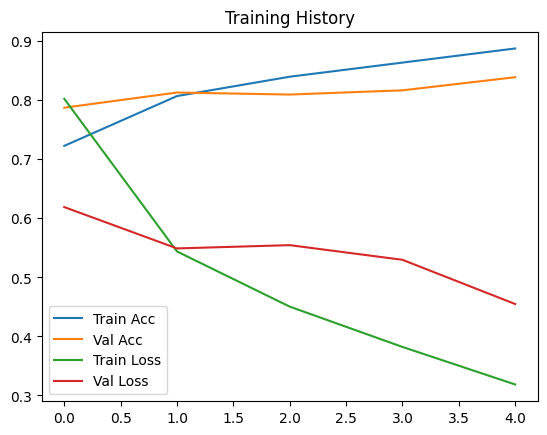

In [12]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Training History')
plt.show()


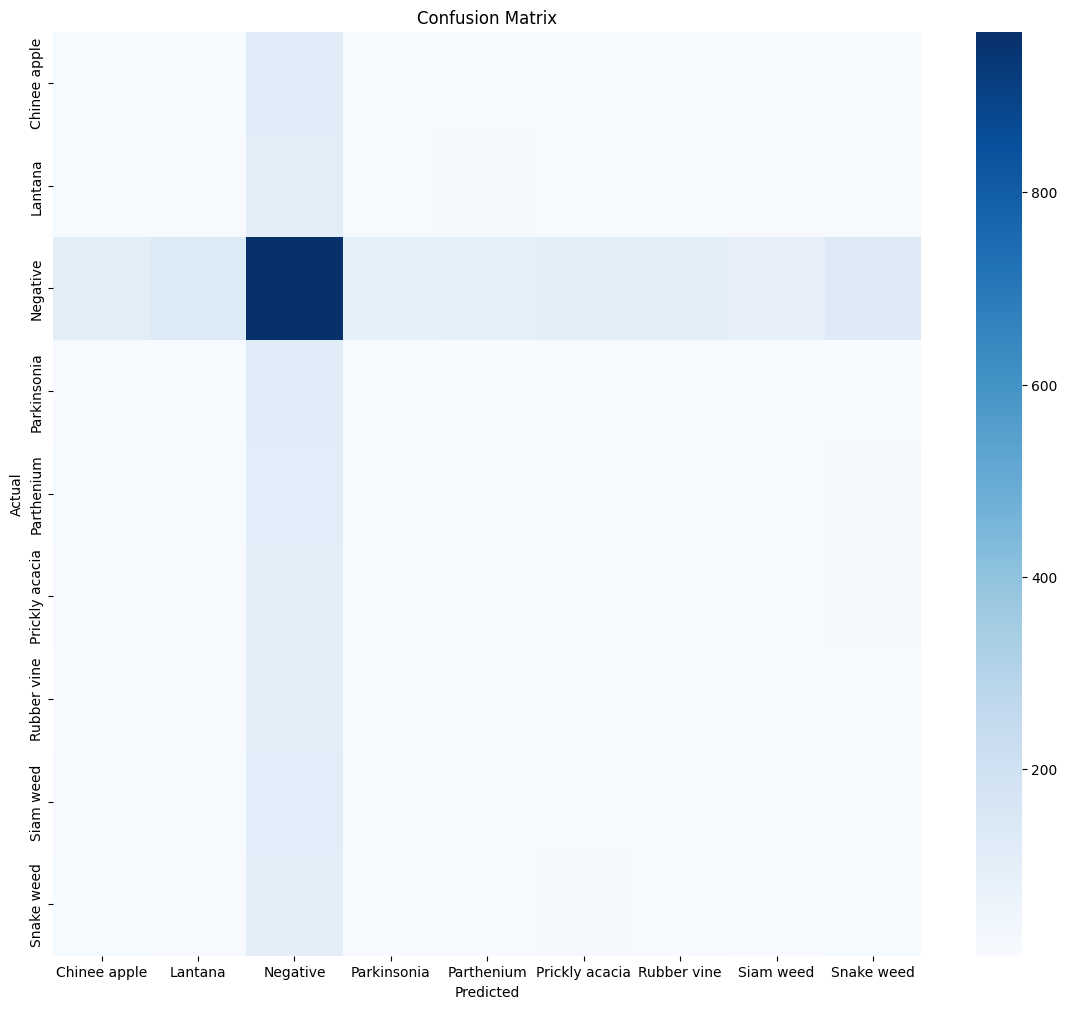

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [17]:
from google.colab import files
uploaded = files.upload()


Saving 20170207-141552-0.jpg to 20170207-141552-0.jpg


In [18]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def predict_image(model, img_path, class_labels, target_size=(224, 224)):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    confidence = np.max(prediction)

    # Show result
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {class_labels[predicted_class]} ({confidence*100:.2f}%)")
    plt.show()

    return class_labels[predicted_class], confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


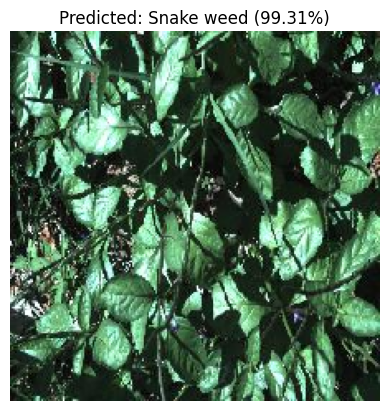

Predicted Class: Snake weed (Confidence: 0.99)


In [19]:
import os

# Assuming only one file uploaded
img_path = next(iter(uploaded))
class_labels = list(train_data.class_indices.keys())  # Use your existing data class mapping

# Call the function
predicted_class, confidence = predict_image(model, img_path, class_labels)
print(f"Predicted Class: {predicted_class} (Confidence: {confidence:.2f})")


In [20]:
# Ensure no shuffle and batch size same as training
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, f1_score

val_data = val_datagen.flow_from_directory(
    'val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Predict
y_pred_probs = model.predict(val_data)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_data.classes
class_labels = list(val_data.class_indices.keys())

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred, target_names=class_labels))

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision (macro):", precision_score(y_true, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_true, y_pred, average='macro'))
print("F1-score (macro):", f1_score(y_true, y_pred, average='macro'))


Found 3506 images belonging to 9 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step
                precision    recall  f1-score   support

  Chinee apple       0.70      0.66      0.68       225
       Lantana       0.75      0.79      0.77       213
      Negative       0.89      0.90      0.90      1822
   Parkinsonia       0.94      0.87      0.91       207
    Parthenium       0.80      0.77      0.78       205
Prickly acacia       0.84      0.78      0.81       213
   Rubber vine       0.85      0.87      0.86       202
     Siam weed       0.84      0.71      0.77       215
    Snake weed       0.61      0.73      0.66       204

      accuracy                           0.84      3506
     macro avg       0.80      0.79      0.79      3506
  weighted avg       0.84      0.84      0.84      3506

Accuracy: 0.8391329150028523
Precision (macro): 0.8016005818340286
Recall (macro): 0.7859123419633
F1-score (macro): 0.7920944183864369


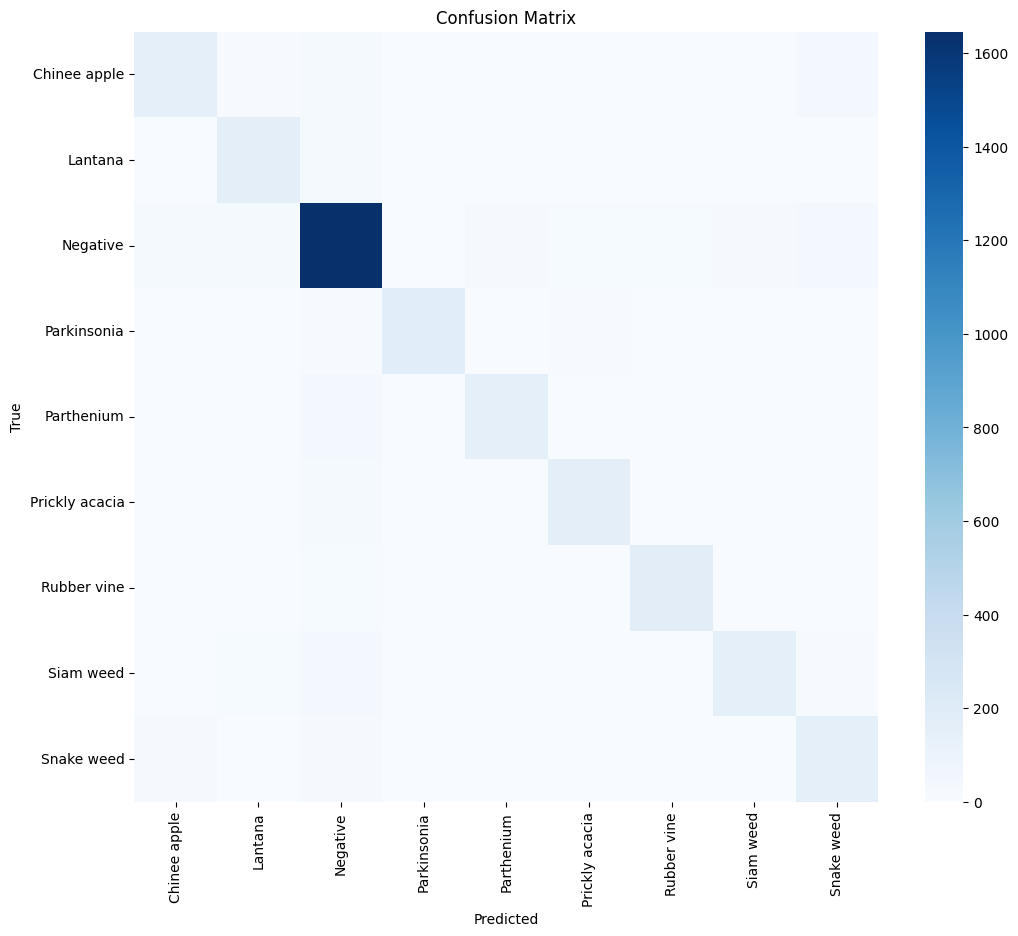

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [22]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_true, y_pred)
print("MSE (class index-wise):", mse)


MSE (class index-wise): 2.932401597261837
